In [1]:
%load_ext autoreload
%autoreload 3 --print
# import os; os.environ['JAX_PLATFORM_NAME'] = 'cpu'
# import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [13]:
from kpsn.project.paths import Project, create_model
from kpsn.io import loaders
from kpsn.models import joint
from kpsn import config
from kpsn.models import instantiation, setup, pose, morph, util as model_util
from kpsn import fitting
from kpsn.fitting import em
from kpsn.io import alignment, features
from kpsn.io.armature import Armature
from kpsn.fitting import methods
from kpsn.fitting import scans
from kpsn.pca import fit_with_center, CenteredPCA
from kpsn.io.dataset_refactor import Dataset
from kpsn.models.morph.lowrank_affine import LRAParams, model as lra_model
import os, sys, shutil
import numpy as np
from pprint import pprint
import jax.numpy as jnp
from kpsn import viz
import optax
import jax
from kpsn.viz import styles
from bidict import bidict
import matplotlib.pyplot as plt
from collections import defaultdict
import os, re
import tqdm
from cmap import Colormap
import joblib as jl

from pathlib import Path
import logging
logging.getLogger().setLevel(logging.INFO)

### Dataset generation functions

In [3]:
# From unit-tests.ipynb

def create_dataset_2d(
    sessions,
    bodies,
    session_bodies,
    n_frames,
    n_components,
    weights,
    means,
    covs,
    transform_matrices,
    transform_biases,
    ref_session=None,
    keypoint_names=None,
    seed=None,
):
    """
    Create a dictionary of keyword arguments for creating a project from a 2D
    test dataset.

    Args:
        sessions (list):
            The number of sessions in the model.
        bodies (list):
            The number of bodies in the model.
        session_bodies (dict):
            A mapping of session names to body names.
        n_frames (int):
            Number of samples to generate for each session.
        n_components (int):
            The number of components in the model.
        weights (np.ndarray, shape (n_sessions, n_components,)):
            The weights of the model, ordered as the list of session names.
        means (np.ndarray, shape (n_components, 2)):
            The means of the Gaussian componets.
        covs (np.ndarray, shape (n_components, 2, 2)):
            The covariances of the Gaussian componets.
        transform_matrices (np.ndarray, shape (n_sessions, 2, 2)):
            The transformation matrices of the affine morph to be applied to the
            data generated by the mixture model.
        transform_biases (np.ndarray, shape (n_sessions, 2)):
            The transformation biases of the affine morph.
        ref_session : str
            The reference session name or `None` to select the first session.
        keypoint_names (list):
            The names of the dimensions of the model data, or `None` to use
            integer indices (converted to strings).
        seed (int):
            The random seed to use for generating the data.

    Returns:
        project_config_kws (dict):
            A dictionary of keyword arguments for creating a project, containing
            keys 'session_names`, `bodies`, `ref_session`.
        raw_keypoints (dict):
            A dictionary of raw keypoint data, containing a key for each
            session name mapping to data of shape (n_frames, 2, 1)
        component_ids (dict):
            A dictionary of arrays containing the component index of each frame
            for each session.
    """

    # convert parameters to arrays
    weights = np.array(weights)
    means = np.array(means)
    covs = np.array(covs)
    transform_matrices = np.array(transform_matrices)
    transform_biases = np.array(transform_biases)

    # check sum to 1 and psd
    assert np.allclose(weights.sum(axis=1), 1)
    assert np.all(np.linalg.eigvals(covs) > 0)

    # setup
    n_bodies = len(bodies)
    n_sessions = len(sessions)
    rng = np.random.default_rng(seed)
    ref_session = ref_session or sessions[0]
    keypoint_names = keypoint_names or [str(i) for i in range(2)]
    keypoint_parents = [None] + [k for k in keypoint_names[:-1]]

    # sample component IDs
    component_ids = {
        s: rng.choice(n_components, size=n_frames, p=weights[i])
        for i, s in enumerate(sessions)
    }
    # sample gaussian noise and transform according to component IDs
    poses = {
        s: np.einsum(
            "ijk,ik->ij",
            np.linalg.cholesky(covs)[component_ids[s]],
            rng.multivariate_normal(np.zeros(2), np.eye(2), size=n_frames),
        )
        + means[component_ids[s]]
        for s in sessions
    }
    # apply affine transform
    observations = {
        s: (np.einsum("ij,aj->ai", transform_matrices[i], poses[s])
        + transform_biases[i])[..., None]
        for i, s in enumerate(sessions)
    }

    # create project config
    project_config_kws = {
        "session_names": sessions,
        "bodies": session_bodies,
        "ref_session": ref_session,
        "keypoint_names": keypoint_names,
        "keypoint_parents": keypoint_parents,
    }

    return project_config_kws, observations, component_ids


def random_lra_morphed(
    n_bodies,
    n_dims,
    n_noise_dims,
    centroid_scale,
    mode_scale,
    data,
    session_names,
    seed=0,
    normalize_mode_upd=False,
):
    """
    Generate a dataset with copies of given data altered according to a random
    low-rank affine morph.

    The morph is generated by finding the PCs of `data` and then sampling
    additive gaussian noise updates the centroid and PCs. This noise is sampled
    from the first `n_noise_dims` PCs of the data.

    Args:
        n_bodies (int):
            The number of bodies in the model.
        n_dims (int):
            The number of PCs the morph should alter in the data.
        n_noise_dims (int):
            The number of PCs of the data the gaussian noise should stray over.
            (sets the number of PCs that feature reduction should keep)
        centroid_scale (float):
            The standard deviation of normal distribution from which to sample
            the centroid of the morphs.
        mode_scale (float):
            The standard deviation of normal distribution from which to sample
            the mode differences in the morphs.
        data (jax array, shape (n_frames, n_keypoints, n_dims)):
        session_names (list):
            Names for the sessions to generate.
        seed (int):
            The random seed to use for generating the data.
        normalize_mode_upd (bool):
            If True, normalize the mode updates to have deterministic length
            `mode_scale`.

    Returns:
        project_config_kws (dict):
            A dictionary of keyword arguments for creating a project, containing
            keys 'session_names`, `bodies`, `ref_session`.
        dataset_keypoints (dict):
            A dictionary of raw keypoint data, containing a key for each
            session name mapping to data of shape (n_frames, n_keypoints, n_spatial)
        params (LRAParams):
            The parameters of the morph.
        true_body_ids (dict):
            A dictionary mapping session names to body ids in `params`.s
    """

    # preprocess inputs
    n_bodies = len(session_names)
    rng = np.random.default_rng(seed)
    features = data.reshape(data.shape[0], -1)
    n_feats = features.shape[1]
    kp_spatial = data.shape[1:]

    # find centroid and dimensions of reference session to morph
    pca = fit_with_center(features)
    centroid = pca._center
    modes = pca._pcadata.pcs()[:n_dims].T

    # sample updates to the centroid and modes in PC space
    centroid_upds = rng.normal(
        scale=centroid_scale, size=(n_bodies, n_noise_dims)
    )
    modes_upds = rng.normal(
        scale=mode_scale, size=(n_bodies, n_noise_dims, n_dims)
    )
    if normalize_mode_upd:
        mode_norm = np.linalg.norm(modes_upds, axis=1, keepdims=True)
        modes_upds = mode_scale * modes_upds / mode_norm
    # translate noise to the full space (first pad with zeros)
    centroid_upds = np.concatenate(
        [centroid_upds, np.zeros((n_bodies, n_feats - n_noise_dims))], axis=1
    )
    modes_upds = np.concatenate(
        [modes_upds, np.zeros((n_bodies, n_feats - n_noise_dims, n_dims))],
        axis=1,
    )
    centroid_upds = pca._pcadata.from_coords(centroid_upds)
    modes_upds = pca._pcadata.from_coords(
        modes_upds.transpose(0, 2, 1)
    ).transpose(0, 2, 1)

    # create a dataset containing copies of the ref session
    # first give each session its own body to automatically assign body ids
    # then update to set the assigned body of each session to the ref body
    canonicalized = Dataset.from_arrays(
        {s: features for s in session_names},
        bodies={s: f"body-{s}" for s in session_names},
        ref_session=session_names[0],
    )
    canonicalized = canonicalized.update(
        session_meta=canonicalized.session_meta.update(
            session_bodies={
                s: f"body-{session_names[0]}" for s in session_names
            }
        ),
    )
    true_body_ids = {
        s: canonicalized.body_id(f"body-{s}") for s in session_names
    }

    # form parameters and apply them to the data
    params = morph.lowrank_affine.LRAParams(
        {
            "n_dims": n_dims,
            "n_bodies": n_bodies,
            "n_feats": n_feats,
            "ref_body": canonicalized.body_id(f"body-{session_names[0]}"),
            "prior_mode": "distance",
            "upd_var_modes": 0.0,
            "upd_var_ofs": 0.0,
            "dist_var": 0.0,
            "modes": jnp.array(modes),
            "offset": jnp.array(centroid),
            "_mode_updates": jnp.array(modes_upds),
            "_offset_updates": jnp.array(centroid_upds),
        }
    )
    observations = model_util.apply_bodies(
        morph.lowrank_affine.model,
        params,
        canonicalized,
        {s: f"body-{s}" for s in canonicalized.sessions},
    )
    dataset_keypoints = {
        s: observations.get_session(s).reshape((-1,) + kp_spatial)
        for s in session_names
    }

    # create project config
    project_config_kws = {
        "session_names": observations.sessions,
        "bodies": {
            s: observations.session_body_name(s) for s in observations.sessions
        },
        "ref_session": observations.session_name(observations.ref_session),
    }

    return (
        project_config_kws,
        dataset_keypoints,
        (params, true_body_ids),
    )


def random_lra_2d(        
    sessions,
    n_frames,
    n_components,
    weights,
    means,
    covs,
    n_morph_dims,
    n_noise_dims,
    centroid_scale,
    mode_scale,
    ref_session=None,
    keypoint_names=None,
    seed=None,
):
    """
    Generate a 2D dataset with a random low-rank affine morph applied.

    Parameters:
    See `create_dataset_2d` and `random_lra_morphed` for details.
    """
    ref_session = sessions[0] if ref_session is None else ref_session
    project_config_2d, raw_2d, component_ids = create_dataset_2d(
        sessions=[ref_session],
        bodies=["id"],
        session_bodies={ref_session: "id"},
        n_frames=n_frames,
        n_components=n_components,
        weights=weights,
        means=means,
        covs=covs,
        transform_matrices=[[[1, 0], [0, 1]]],
        transform_biases=[[0, 0]],
        ref_session=ref_session,
        keypoint_names=keypoint_names,
        seed=seed,
    )

    project_config_lra, dataset_keypoints, (params, body_ids) = (
        random_lra_morphed(
            len(sessions),
            n_morph_dims,
            n_noise_dims,
            centroid_scale,
            mode_scale,
            raw_2d[ref_session],
            sessions,
            seed=seed + 1,
        )
    )
    project_config_lra["keypoint_names"] = project_config_2d["keypoint_names"]
    project_config_lra["keypoint_parents"] = project_config_2d[
        "keypoint_parents"
    ]

    return (
        project_config_lra,
        dataset_keypoints,
        (params, body_ids, component_ids),
)


### Dataset and project generation

In [4]:
project_config_kws, dataset_keypoints, (true_params, true_body_ids, component_ids) = random_lra_2d(
    sessions = ["A", "B"],
    n_frames = 300,
    n_components = 3,
    weights = np.array([[4, 1, 1], [1, 1, 4]]) / 6,
    means = [
        [1, 0],
        [0, 1],
        [-1, 0]
    ],
    covs = np.array([
        [[1, 0.8], [0.8, 1]],
        [[1, 0], [0, 1]],
        [[1, -0.8], [-0.8, 1]],
    ]) / 9,
    n_morph_dims=1,
    n_noise_dims=1,
    centroid_scale=0.5,
    mode_scale=0.5,
    ref_session = "A",
    keypoint_names = None,
    seed = 0,
)
component_ids = {s: component_ids["A"] for s in ["A", "B"]}

In [5]:
# Create base project config to override

project_dir = Path('../projects/lra-init-2d')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')


loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='none',
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

### Optimization problem

Let $X, X_n \in \mathbb{R}^{N\times K}$ be matrix of $K$ column-wise reference and target animal data points respectively. We seek a map $M\in \mathbb{R}^{N \times N}$ that best aligns the covariance structure of $MX$ with that of $X_n$ that is (a) low rank and (b) does not drastically alter the data.
Let $P\Sigma P^T$ be the SVD of the reference covariance $XX^T$. To satisfy the rank condition, we parameterize $M$ as $(P + \hat P)P^T$ for $\hat P$ with only the first $L$ columns nonzero. That is, we proceed by solving $$\begin{align*}
\arg\min_{\hat P}\left |(P+\hat P)P^T XX^TP(P + \hat P)^T - X_nX_n^T\right| &= 
\arg\min_{\hat P}\left |(P+\hat P)\Sigma^2(P + \hat P)^T - X_nX_n^T\right|
\end{align*}.$$
If the chosen matrix norm is unitarily invariant (e.g. Frobenius) then the problem further simplifies in terms of the SVD $X_nX_n^T = Q\Gamma Q^T$ as $$\begin{align*}
\arg\min_{\hat P}\left|Q^T(P+\hat P)\Sigma^2(P + \hat P)^TQ - \Gamma^2 \right|
\end{align*}$$To avoid large rotations we add $\alpha |\hat{P}|$ to the minimization.


In [38]:
ref_data = jnp.array(dataset_keypoints["A"])
alt_data = jnp.array(dataset_keypoints["B"])
ref_sigma, ref_pc = jnp.linalg.eigh(jnp.cov(ref_data.reshape(-1, 2).T))
alt_sigma, alt_pc = jnp.linalg.eigh(jnp.cov(alt_data.reshape(-1, 2).T))


def objective(ref_pc, ref_sigma, alt_pc, alt_sigma, n_upd, alpha = 0):
    """
    Parameters:
    ref_pc, alt_pc : jnp.ndarray, shape (..., n_dims, n_pc = n_dims)
        The principal components of the reference and alternative data.
    ref_sigma, alt_sigma : jnp.ndarray, shape (..., n_pc = n_dims)
        The singular values of the reference and alternative data.
    n_upd : int
        The number of principal components allowed to update
    """
    const_pc = ref_pc[..., n_upd:] * ref_sigma[..., None, n_upd:]

    @jax.jit
    def _objective(upds):
        """
        Parameters:
        upds : jnp.ndarray, shape (..., n_dims, n_upd <= n_dims)
            The updates to the principal components.
        """
        updated = (ref_pc[..., :n_upd] + upds) * ref_sigma[..., None, :n_upd]
        updated = jnp.concatenate([updated, const_pc], axis=-1)
        A = alt_pc.transpose(-2, -1) @ updated
        morphed = A @ A.transpose(-2, -1)
        reg = alpha * (upds ** 2).sum()
        return ((morphed - alt_sigma**2) ** 2).sum() + reg

    return _objective

In [43]:
lr = 1e-2
n_upd = 1
alpha = 1e-1
opt = optax.adam(learning_rate = lr)
obj = objective(ref_pc, ref_sigma, alt_pc, alt_sigma, n_upd, alpha)
upds_init = jnp.zeros(ref_pc.shape[:-1] + (n_upd,))

n_steps = 100
ckpt_every = 10
losses = np.zeros(n_steps)
upds_hist = np.zeros((n_steps // ckpt_every, *upds_init.shape))
upds_curr = upds_init
opt_state = opt.init(upds_init)

for i in tqdm.trange(n_steps):
    loss, grad = jax.value_and_grad(obj)(upds_curr)
    losses[i] = loss
    param_step, opt_state = opt.update(grad, opt_state)
    upds_curr = optax.apply_updates(upds_curr, param_step)
    if i % ckpt_every == 0:
        upds_hist[i // ckpt_every] = np.array(upds_curr)

100%|██████████| 100/100 [00:00<00:00, 750.67it/s]


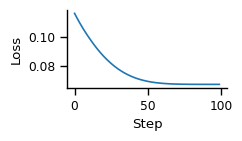

In [44]:
fig, ax = plt.subplots(figsize = (2.5, 1.5))
ax.plot(losses)
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
plotter.finalize(fig, None)
